# Identifying Optotagged Units

### Environment Setup

In [1]:
import os
import time

import fsspec
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from dandi import dandiapi
from pynwb import NWBHDF5IO

%matplotlib inline

### Downloading File

In [2]:
dandiset_id = "000248"
dandi_filepath = "sub_1171903433/sub_1171903433sess_1181330601/sub_1171903433+sess_1181330601_ecephys.nwb"
# dandiset_id = "000253"
# dandi_filepath = "sub_1169714193/sub_1169714193sess_1180116198/sub_1169714193+sess_1180116198_ecephys.nwb"
# dandiset_id = "000021"
# dandi_filepath = "sub-703279277/sub-703279277_ses-719161530.nwb"

authenticate = True
dandi_api_key = "7b74c449992670033c1c6018648afcac078527a9"

In [3]:
if authenticate:
    client = dandiapi.DandiAPIClient(token=dandi_api_key)
else:
    client = dandiapi.DandiAPIClient()
my_dandiset = client.get_dandiset(dandiset_id)

A newer version (0.49.1) of dandi/dandi-cli is available. You are using 0.46.3


In [4]:
filename = dandi_filepath.split("/")[-1]
filepath = f"./{filename}"
file = my_dandiset.get_asset_by_path(dandi_filepath)

In [ ]:
# this may take awhile, especially if the file to download is large
file.download(filepath)

print(f"Downloaded file to {filepath}")

### Extracting Optogenetic Stimulus Data and Units Data

In [5]:
io = NWBHDF5IO(filepath, mode="r", load_namespaces=True)
nwb = io.read()

C:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
C:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
C:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [6]:
stim_table = nwb.processing["optotagging"]["optogenetic_stimulation"]
timestamps = nwb.processing["optotagging"]["optotagging"].timestamps
data = nwb.processing["optotagging"]["optotagging"].data

In [7]:
stim_table[:]

,start_time,condition,level,stop_time,stimulus_name,duration,tags,timeseries
id,,,,,,,,
0,7351.42759,half-period of a cosine wave,1.4,7351.44009,raised_cosine,0.0125,[optical_stimulation],"[(0, 1, optotagging pynwb.base.TimeSeries at 0..."
1,7354.21649,1 second of 100 Hz pulse train. Each pulse is ...,1.4,7354.22649,100 hz pulse train,0.0100,[optical_stimulation],"[(1, 1, optotagging pynwb.base.TimeSeries at 0..."
2,7356.83859,half-period of a cosine wave,1.4,7356.85109,raised_cosine,0.0125,[optical_stimulation],"[(2, 1, optotagging pynwb.base.TimeSeries at 0..."
3,7359.21890,Each pulse is 6 ms wide,1.4,7359.25190,40 hz pulse train,0.0330,[optical_stimulation],"[(3, 1, optotagging pynwb.base.TimeSeries at 0..."
4,7361.74981,1 second of 40 Hz pulse train. Each pulse is 2...,1.4,7361.77481,fast_pulses,0.0250,[optical_stimulation],"[(4, 1, optotagging pynwb.base.TimeSeries at 0..."
...,...,...,...,...,...,...,...,...
595,8953.87449,1 second square pulse: continuously on for 1s,1.4,8954.87449,Square Pulse,1.0000,[optical_stimulation],"[(595, 1, optotagging pynwb.base.TimeSeries at..."
596,8956.08433,half-period of a cosine wave,1.4,8956.09683,raised_cosine,0.0125,[optical_stimulation],"[(596, 1, optotagging pynwb.base.TimeSeries at..."
597,8958.83404,1 second of 5Hz pulse train. Each pulse is 2 m...,1.4,8959.03404,pulse,0.2000,[optical_stimulation],"[(597, 1, optotagging pynwb.base.TimeSeries at..."


In [8]:
set(stim_table.duration)

{0.0100000000002182,
 0.0124999999998181,
 0.0125000000007275,
 0.016700000000128,
 0.0200000000004365,
 0.0249999999996362,
 0.032999999999447,
 0.0330000000003565,
 0.0499999999992724,
 0.0500000000001819,
 0.1000000000003638,
 0.1999999999998181,
 0.2000000000007276,
 1.0}

In [9]:
units = nwb.units
units[:]

,spread,PT_ratio,waveform_duration,d_prime,cumulative_drift,silhouette_score,cluster_id,l_ratio,quality,nn_miss_rate,...,nn_hit_rate,firing_rate,isi_violations,repolarization_slope,presence_ratio,waveform_halfwidth,max_drift,spike_times,spike_amplitudes,waveform_mean
id,,,,,,,,,,,,,,,,,,,,,
18,30.0,0.781018,0.178559,6.626220,303.30,-1.000000,0,0.000508,good,0.000811,...,0.993333,3.197243,0.024439,1.866277,0.99,0.096147,34.00,"[8.014794709919338, 8.293461076304402, 8.82879...","[0.00012949004762110477, 0.0001213092796695316...","[[0.0, 0.47657999999999645, 0.0772199999999962..."
19,60.0,0.532080,0.260972,4.271249,207.72,0.212787,1,0.001196,good,0.009654,...,0.996667,5.193174,0.030878,1.107999,0.94,0.137353,40.17,"[50.997015060375595, 51.41301461210832, 51.757...","[0.00037993274566925847, 0.0003816832117861771...","[[0.0, 0.3112200000000027, -0.9989849999999991..."
20,110.0,0.445433,0.206030,4.697081,522.80,0.113688,2,0.005522,noise,0.001040,...,0.933856,2.205221,1.335685,1.209945,0.99,0.178559,24.25,"[4.837431467073574, 5.070397882703384, 5.38189...","[0.0002686896757199117, 0.00024659037033441513...","[[0.0, 0.8490299999999991, 0.6362850000000018,..."
21,70.0,0.626257,0.192295,7.748337,251.17,0.183368,3,0.000009,good,0.000455,...,0.992215,3.091598,0.043563,1.542309,0.99,0.123618,11.10,"[29.302205104647573, 29.363438371997976, 29.37...","[0.0004903548978179461, 0.0005185625567175445,...","[[0.0, -0.2427750000000014, -0.060255000000000..."
22,60.0,0.339982,0.274707,3.683361,597.76,0.129635,4,0.006094,good,0.000417,...,0.986476,3.686589,0.082718,0.545493,0.99,0.178559,60.24,"[4.8927647407816135, 4.986831306085279, 5.2071...","[0.0003544778954586829, 0.00028605818602693036...","[[0.0, 1.3367249999999982, 2.632305000000001, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2948,110.0,0.243913,0.645561,5.263379,0.00,-1.000000,491,0.000916,noise,0.000067,...,0.111111,0.033438,0.000000,1.388151,0.64,0.192295,25.98,"[559.8154874566576, 626.7480256759407, 1116.58...","[0.0002490023360184234, 0.0002378723777360203,...","[[0.0, -0.483936877076399, -0.1684385382059652..."
2949,80.0,0.482246,0.535678,3.226620,117.80,0.053558,492,0.002554,good,0.005293,...,0.938900,14.340288,0.022677,0.880808,0.99,0.219765,29.29,"[5.032223943330324, 5.09265704030299, 5.392255...","[0.00040769706973461733, 0.000407024418762033,...","[[0.0, 0.7374900000000029, -0.3812250000000112..."
2950,60.0,0.378942,0.549414,4.277383,262.15,0.078519,493,0.001957,good,0.000134,...,0.629630,0.560774,0.132406,0.778171,0.99,0.151089,32.63,"[14.087255194747007, 14.914585292298883, 28.23...","[0.00015895859271115842, 0.0002561913195102825...","[[0.0, -0.8656050000000075, -0.609180000000009..."


In [10]:
len(stim_table)

600

### Selecting Units and Stimuli

In [11]:
# stim_select = lambda row: float(row.duration) > 0.009 and float(row.duration) < 0.012
stim_select = lambda row: True
stim_times = [float(row.start_time) for row in stim_table if stim_select(row)]

# unit_select = lambda row: float(row.firing_rate) > 4
unit_select = lambda row: True
units_spike_times = [row.spike_times.iloc[0] for row in units if unit_select(row)]
units_spike_times = units["spike_times"]

### Plotting Unit Responses

In [12]:
time_resolution = 0.0005
bin_edges = np.arange(-0.01, 0.025, time_resolution)
spike_matrix = np.zeros( (len(units_spike_times), len(bin_edges), len(stim_times)) )

for unit_idx in range(len(units_spike_times)):
    spike_times = units_spike_times[unit_idx]

    for stim_idx, stim_time in enumerate(stim_times):
        # get spike times that fall within the bin's time range relative to the stim time        
        first_bin_time = stim_time + bin_edges[0]
        last_bin_time = stim_time + bin_edges[-1]
        first_spike_in_range, last_spike_in_range = np.searchsorted(spike_times, [first_bin_time, last_bin_time])
        spike_times_in_range = spike_times[first_spike_in_range:last_spike_in_range]

        # convert spike times into relative time bin indices
        bin_indices = ((spike_times_in_range - (first_bin_time)) / time_resolution).astype(int)
        
        # mark that there is a spike for these bin times for this unit on this stim trial
        spike_matrix[unit_idx, bin_indices, stim_idx] = 1

# aggregate all stim trials to get total spikes by unit over time
spike_counts = np.sum(spike_matrix, axis=2)

In [28]:
def show_counts(counts_matrix, stim_bounds=[], title="", c_label="", vmin=None, vmax=None):
    fig, ax = plt.subplots(figsize=(6,12)) # change fig size for different plot dimensions
    img = ax.imshow(counts_matrix, 
                    extent=[np.min(bin_edges), np.max(bin_edges), 0, len(counts_matrix)], 
                    aspect="auto",
                    vmin=vmin,
                    vmax=vmax) # change vmax to get a better depiction of your data

    for bound in stim_bounds:
        ax.plot([bound, bound],[0, len(counts_matrix)], ':', color='white', linewidth=1.0)

    ax.set_xlabel("Time relative to stimulus onset (s)")
    ax.set_ylabel("Unit #")

    ax.set_title(title)

    cbar = fig.colorbar(img, shrink=0.5)
    cbar.set_label(c_label)

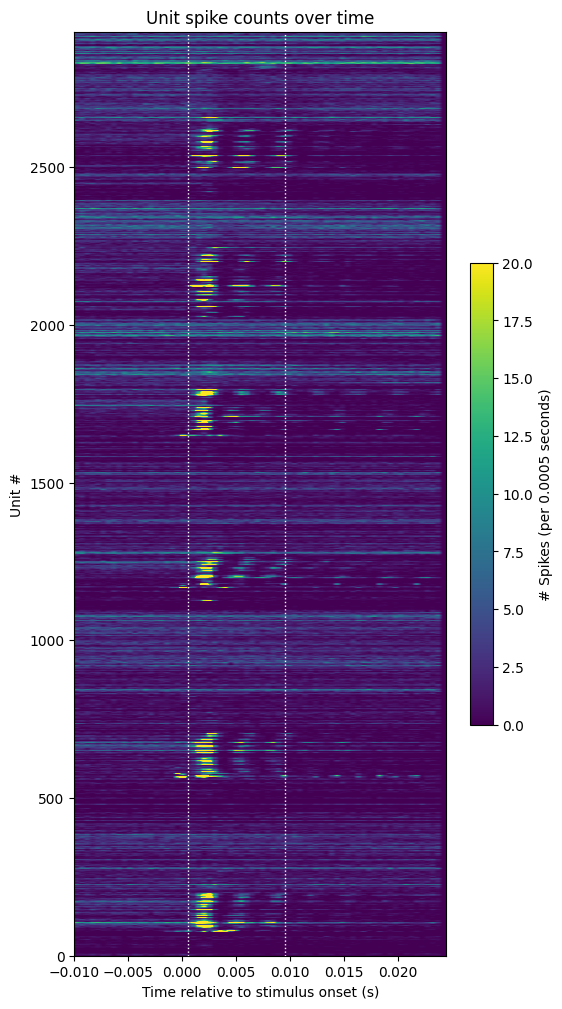

In [29]:
show_counts(spike_counts,
                  stim_bounds=[0.0005, 0.0095], 
                  title="Unit spike counts over time", 
                  c_label=f"# Spikes (per {time_resolution} seconds)",
                  vmin=0,
                  vmax=20
                 )

### Identifying Optotagged Units

In [30]:
baseline_end_time = -0.002
baseline_time_interval = baseline_end_time - bin_edges[0]
baseline_end_idx = ((baseline_end_time - bin_edges[0]) / time_resolution).astype(int)

array([ True,  True,  True, ...,  True,  True,  True])

In [31]:
bl_mean_counts = np.mean(spike_counts[:,:baseline_end_idx],axis=1)
bl_mean_counts = np.expand_dims(bl_mean_counts, axis=1)

bl_std_counts = np.std(spike_counts[:,:baseline_end_idx],axis=1)
bl_std_counts[bl_std_counts == 0] = 1
bl_std_counts = np.expand_dims(bl_std_counts, axis=1)

normalized_spike_counts = (spike_counts - bl_mean_counts) / bl_std_counts

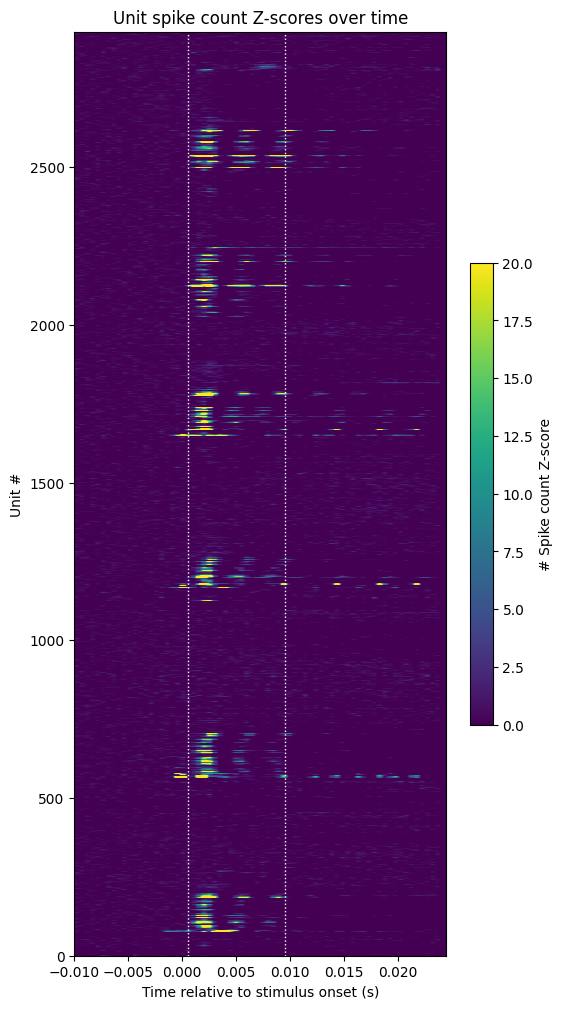

In [32]:
show_counts(normalized_spike_counts,
                  stim_bounds=[0.0005, 0.0095], 
                  title="Unit spike count Z-scores over time", 
                  c_label=f"# Spike count Z-score", 
                  vmin=0, 
                  vmax=20)

In [38]:
sorted_indices = np.argsort(np.max(normalized_spike_counts, axis=1))
sorted_indices.shape
sorted_normalized_spike_counts = np.take(normalized_spike_counts, sorted_indices, axis=0)

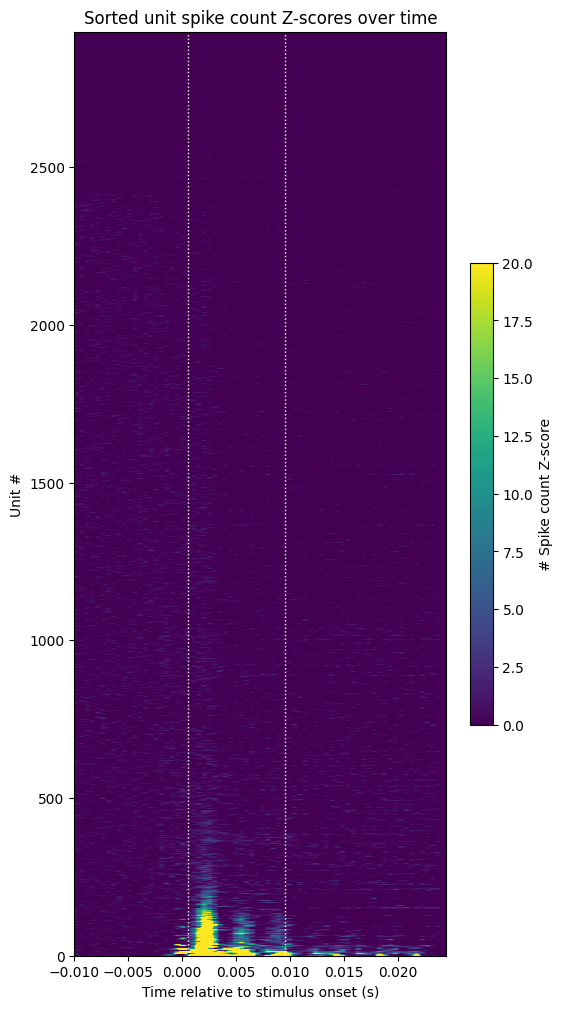

In [39]:
show_counts(sorted_normalized_spike_counts,
                  stim_bounds=[0.0005, 0.0095], 
                  title="Sorted unit spike count Z-scores over time", 
                  c_label=f"# Spike count Z-score", 
                  vmin=0, 
                  vmax=20)

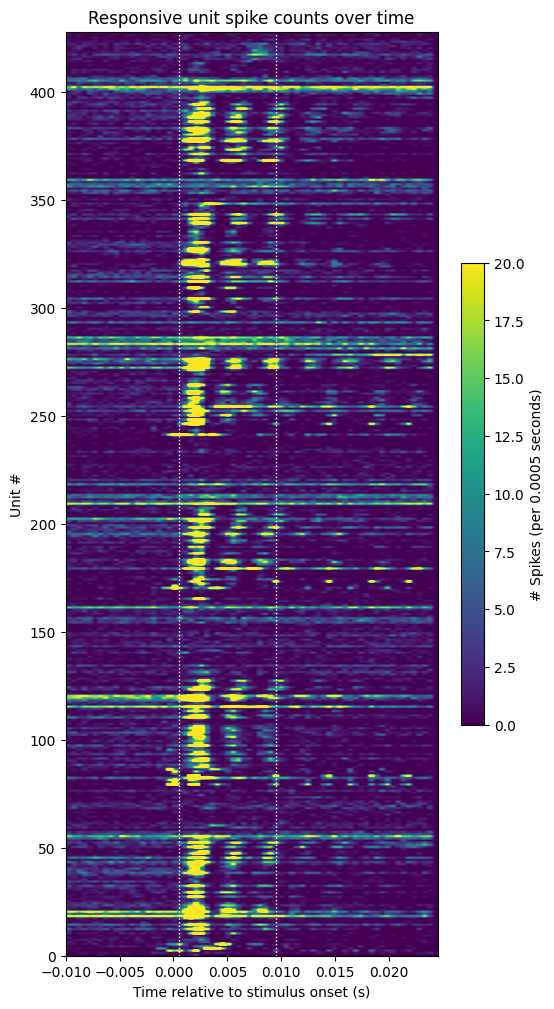

In [41]:
filtered_spike_counts = spike_counts[np.max(normalized_spike_counts, axis=1) > 5]
show_counts(filtered_spike_counts,
                  stim_bounds=[0.0005, 0.0095], 
                  title="Responsive unit spike counts over time", 
                  c_label=f"# Spikes (per {time_resolution} seconds)", 
                  vmin=0, 
                  vmax=20)

### Showing optotagged waveforms

In [ ]:
cre_pos_units = spike_counts[(evoked_rate / (baseline_rate + 1)) > 2]

In [ ]:

plt.figure(figsize=(5,5))

for unit_id in cre_pos_units:
    
    peak_channel = session.units.loc[unit_id].peak_channel_id
    wv = session.mean_waveforms[unit_id].sel(channel_id = peak_channel)
    
    plt.plot(wv.time * 1000, wv, 'k', alpha=0.3)

plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (microvolts)')
_ =plt.plot([1.0, 1.0],[-160, 100],':c')